In [2]:
# Setup
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My\ Drive/BDSA_Project/
!ls

Mounted at /content/drive
/content/drive/My Drive/BDSA_Project
 annotations				    model_mobilenetv2.pt.index
 checkpoint				    model.pt
'Coronavirus Template.gslides'		    output
 demo_ppt.gslides			    pretrained_caffe_ssd
 final_report.gslides			    pytorch-fasterrcnn.ipynb
 images					    pytorch-ssd2.ipynb
 keras_loss_function			    pytorch-ssd3.ipynb
 model_detectron2.ipynb			    pytorch-ssd.ipynb
 model_fasterrcnn.pt			    Team6-WorshopPresentation.mov
 model_mobilenetv2			    Voiceovers
 model_mobilenetv2.ipynb		   'webcam implementation'
 model_mobilenetv2.pt.data-00000-of-00001  'Workshop Presentation.gslides'


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ModuleNotFoundError: ignored

In [ ]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [ ]:
imgs = list(sorted(os.listdir("images/")))

In [ ]:
labels = list(sorted(os.listdir("annotations/")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("images/")))

    def __getitem__(self, idx):
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# transforms

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
transform = transforms.Compose([
        transforms.ToTensor(), 
    ])
data = MaskDataset(transform)
old_loader = torch.utils.data.DataLoader(
 data, batch_size=4, collate_fn=collate_fn)

856

In [ ]:
def load_data(test_split):
    """Loads the data"""
    def collate_fn(batch):
      return tuple(zip(*batch))
    data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])
    dataset = MaskDataset(data_transform)
    # Create indices for the split
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    train_size = dataset_size - test_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                               [train_size, test_size])
    # print(len(train_dataset.dataset), len(test_dataset))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1,
        collate_fn=collate_fn
        )

    return train_loader, test_loader

data_loader, test_loader = load_data(0.1)

In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [ ]:
model = get_model_instance_segmentation(3)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in test_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    print(imgs)
    break

[{'boxes': tensor([[251.,  22., 270.,  44.]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'image_id': tensor([602], device='cuda:0')}]
[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6549, 0.6549, 0.6549,  ..., 0.6784, 0.6784, 0.6745],
         [0.6549, 0.6549, 0.6549,  ..., 0.6784, 0.6784, 0.6784],
         ...,
         [0.2000, 0.2118, 0.2392,  ..., 0.7020, 0.6706, 0.7176],
         [0.2431, 0.2510, 0.2588,  ..., 0.4314, 0.5529, 0.5529],
         [0.2627, 0.2510, 0.2471,  ..., 0.6157, 0.6706, 0.5686]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6980, 0.6980, 0.6980,  ..., 0.7216, 0.7216, 0.7176],
         [0.6980, 0.6980, 0.6980,  ..., 0.7216, 0.7216, 0.7216],
         ...,
         [0.2275, 0.2431, 0.2824,  ..., 0.6353, 0.6078, 0.6549],
         [0.2824, 0.2863, 0.3020,  ..., 0.3922, 0.5059, 0.5059],
         [0.3059, 0.2941, 0.2863,  ..., 0.5608, 0.6118, 0.5137]],

        [[0.0000, 0.0000, 0.0000,  ...

# Train Model

In [ ]:

num_epochs = 30
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(epoch_loss)


tensor(102.4807, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69.3303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(55.2806, device='cuda:0', grad_fn=<AddBackward0>)
tensor(49.0809, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.0366, device='cuda:0', grad_fn=<AddBackward0>)
tensor(42.9502, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.5799, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1468, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.3831, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.9690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.6330, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.3459, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.6222, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.3946, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.2398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.0566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.3857, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.5392, device='cuda:0

In [ ]:
torch.save(model.state_dict(),'model_fasterrcnn.pt')

In [ ]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0].item(), boxB[0].item())
    yA = max(boxA[1].item(), boxB[1].item())
    xB = min(boxA[2].item(), boxB[2].item())
    yB = min(boxA[3].item(), boxB[3].item())

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [ ]:
model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load('model_fasterrcnn.pt'))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
for (i,d) in zip([1,2,3],[3,4,5,6,7]):
  print(d)

3
4
5


In [ ]:
len(data_loader)

214

In [ ]:
# model.eval()
correct_mask_predictions = 0;
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
total_test_size = 0;
import datetime
dt_now = datetime.datetime.now()
for imgs, annotations in test_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        pred = model(imgs)
        match_map = {}
        for target_id, target_box in enumerate(annotations[0]["boxes"]):
          matches = []
          for box in pred[0]["boxes"]:
            matches.append(bb_intersection_over_union(target_box, box))
          max_match = max(matches)
          if(max_match >= 0.51):
            match_map[target_id] = matches.index(max_match)
          else:
            match_map[target_id] = None
        for target_id, target_box in enumerate(annotations[0]["boxes"]):
         target_label = annotations[0]["labels"][target_id]
         match_id = match_map[target_id]
         if(match_id):
          pred_label = pred[0]["labels"][match_id]
         else:
           pred_label = torch.tensor([-1]).to(device)
         if(target_label == pred_label):
           correct_mask_predictions += 1
           if(pred_label.item() == 2):
              true_positive += 1
           else:
              true_negative += 1
         else:
           if(pred_label.item() == 2):
             false_positive += 1
           else:
             false_negative += 1

delta = datetime.datetime.now() - dt_now
print("Accuracy", (true_positive+true_negative)/(true_positive+true_negative+ false_positive+ false_negative))
print("Recall", (true_positive / (true_positive + false_negative)))
print("Precision", (true_positive) / (true_positive + false_positive))
print("Avg Time per image", delta.total_seconds()/len(test_loader))

Accuracy 0.5833333333333334
Recall 0.6
Precision 0.8571428571428571
Avg Time per image 0.15134757647058825


In [ ]:
import datetime
dt_now = datetime.datetime.now()

In [ ]:
(datetime.datetime.now() - dt_now).total_seconds()

178.249958

Predict with loaded model


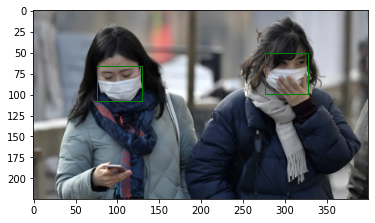

target


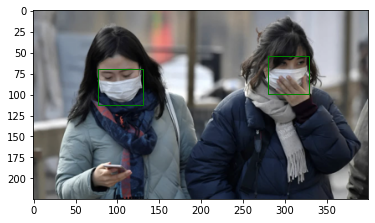

Predict with loaded model


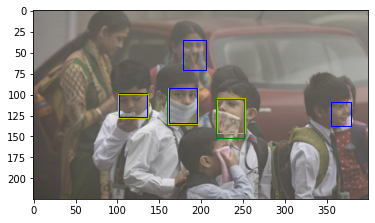

target


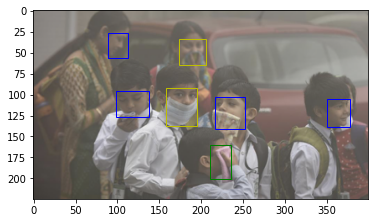

Predict with loaded model


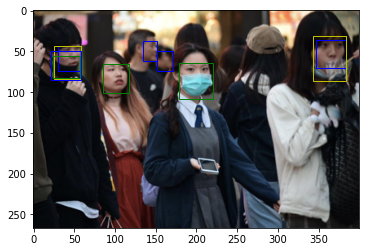

target


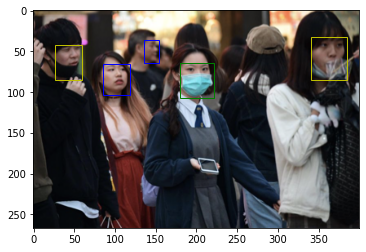

Predict with loaded model


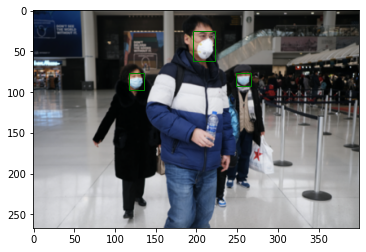

target


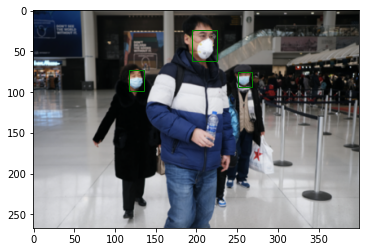

Predict with loaded model


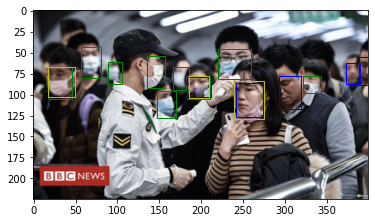

target


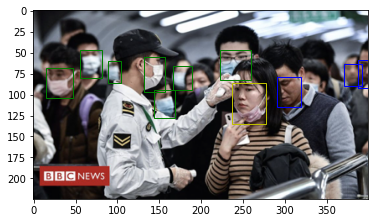

In [ ]:
samples = 5
curr = 0
for imgs, annotations in test_loader:
        if(curr == samples):
          break
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        pred = model(imgs)
        print("Predict with loaded model")
        plot_image(imgs[0], pred[0])
        print('target')
        plot_image(imgs[0], annotations[0])
        curr += 1

# Function to plot image

In [ ]:
len(imgs)

4

In [ ]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    color_map = { 1: 'b', 2: 'g', 3: 'y'}
    for idx, box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box
        label = annotation['labels'].cpu().data[idx].item()
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color_map[label],facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


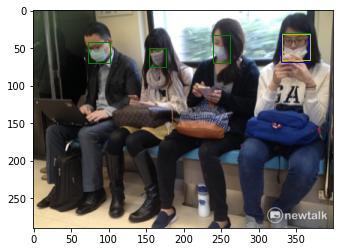

Target


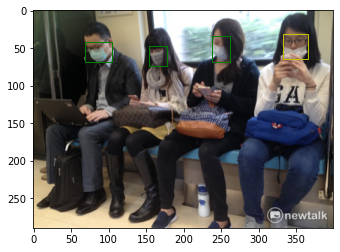

In [ ]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [ ]:
torch.save(model.state_dict(),'model_fasterrcnn.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [ ]:
model2.load_state_dict(torch.load('model_fasterrcnn.pt'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Load Model

In [ ]:
pred2 = model2(imgs)
print(pred2[2])
print(annotations[2])

{'boxes': tensor([[155.1572,  49.1380, 175.6062,  72.9862],
        [ 70.5797,  43.2524, 100.4928,  68.6175],
        [239.1853,  34.2691, 262.7345,  68.7883],
        [332.1157,  31.5314, 366.4144,  66.2397],
        [332.1426,  31.3229, 364.7062,  62.8521],
        [332.6735,  31.5303, 364.9316,  64.3132]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([2, 2, 2, 2, 3, 1], device='cuda:0'), 'scores': tensor([0.9915, 0.9876, 0.9622, 0.8742, 0.3415, 0.1639], device='cuda:0',
       grad_fn=<IndexBackward>)}
{'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([2, 2, 2, 3], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}


Predict with loaded model


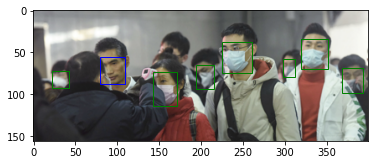

target


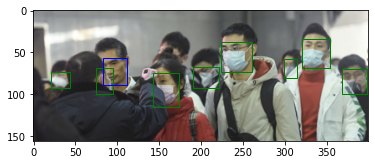

In [ ]:
print("Predict with loaded model")
plot_image(imgs[1], pred2[1])
print('target')
plot_image(imgs[1], annotations[1])

In [ ]:
# Get Prediction Time
# false Positive (what cases ?), precision, recall
# Description of dataset (ditribution, diversity, )
# Image size
